# Run inference on a test set and save predictions
Date: December 28, 2020  
Author: Joshua Eckels (eckelsjd@rose-hulman.edu)  

## Issues
- load_learner requires the IoU function be defined somewhere (need to train and then export the learner with learner.metrics = [] next time)
- source code changed on torch.nn conv2d
- export to .onnx file doesn't work

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import torch
from torch.nn import functional as F
import os

# problem with fastia cuda usage - blows gpu memory away
# defaults.device = 'cpu'

In [3]:
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [6]:
# Load learner from .pkl file
# learn.export() # to 'learn.path/'export.pkl'
test_dir = Path("../test");
learn = load_learner(path="../models/",file="export_0_0009_KH.pkl",test=SegmentationItemList.from_folder(test_dir/"testset"),tfm_y=False)

/home/eckelsjd/anaconda3/envs/fastai1/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/eckelsjd/anaconda3/envs/fastai1/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/eckelsjd/anaconda3/envs/fastai1/lib/python3.8/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you c

In [7]:
num_test = len(learn.data.test_ds.items);

In [8]:
# Determine type of image
# filename = str(learn.data.test_ds.items[0])
# if '_real' in filename:
#     token = '_real'
# elif '_imaginary' in filename:
#     token = '_imaginary'
# else:
#     print("Error: image needs to contain one of the above")

# Just do real images for testing
token = '_real'

In [9]:
# get the filename of the prediction image
get_pred_fn = lambda x: test_dir/"predictions"/f'{x.stem.split(token)[0]}_pred{x.suffix}'

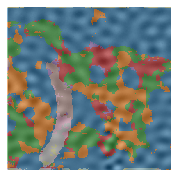

In [10]:
# loop through all test images; run inference one at a time
for i in range(num_test):
    img_fn = str(learn.data.test_ds.items[i]).split("/")[-1] 
    
    if not token in img_fn:
        continue # skip imaginary
        
    test_img = open_image(learn.data.test_ds.items[i])
    
    # Show single prediction
    pred = learn.predict(test_img)
    mask = pred[0]
    test_img.show(y=mask)
    # pred = tuple(ImageSegment,Tensor[1,720,960],Tensor[32,720,960])
    #      = tuple(mask image, class pixel values, probabilities)
    
    # Save mask image to predictions folder
    X = image2np(mask.data).astype(np.uint8)
    pred_fn = get_pred_fn(Path(img_fn))
    PIL.Image.fromarray(X).save(Path(pred_fn))

In [ ]:
# Batch prediction (RUNS OUT OF MEMORY FOR LARGE TEST SETS)
# preds,y = learn.get_preds(ds_type=DatasetType.Test)
# predicted_masks = np.argmax(preds,axis=1) # get highest class probabilities (dim 1)
# predicted_masks = torch.unsqueeze(predicted_masks,1) # shape = [len(test),1,400,400]

In [ ]:
# Loop through each item in the testset and save as image (RUNS OUT OF MEMORY)
# for i in range(num_test):
#     img_fn = str(learn.data.test_ds.items[i]).split("/")[-1] 
    
#     if not token in img_fn:
#         continue # skip imaginary
        
#     mask = ImageSegment(predicted_masks[i]); # convert torch.Tensor to fastai.image.ImageSegment
#     test_img = learn.data.test_dl.dataset[i][0]; 
#     print(img_fn)
#     test_img.show(y=mask); # optional display here
    
#     # Save mask image
#     X = image2np(mask.data).astype(np.uint8)
#     pred_fn = get_pred_fn(Path(img_fn))
#     PIL.Image.fromarray(X).save(Path(pred_fn))

In [ ]:
# .onnx needs an example tensor X
# img_size = learn.data.test_dl.dataset[0][0].px.size()
# X = torch.randn(img_size,requires_grad=False).unsqueeze(0).cuda()
# X.size()

# Export to .onnx (DOESN'T WORK but would be cool)
# Could import model.onnx to MATLAB and do all the inference/predictions there
# learn.model.eval();
# torch_out = torch.onnx.export(learn.model, X, "model.onnx", export_params=True,verbose=True)